# Assignment 11b.1 - SVM Training
* Felipe Pinheiro - 155298
* Guilherme Jardim - 203834

This assignment aims to:

1. Apply studied transformation attribute extraction techniques
1. Train a Support Vector Machine (SVM) model to classify white matter lesions in FLAIR MRIs between stroke (AVC, in this case ischemic) and multiple sclerosis (EM, which is demyelinating)
1. Generate output classes using a separate test dataset

In [1]:
import os
import glob
import copy
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from PIL import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, balanced_accuracy_score, accuracy_score
import scipy
import pickle

Data loading is made using enviroment variables in order to protect directory privacy

In [2]:
load_dotenv('test.env')
raw_dir = os.environ['RAW_DIR']
interim_dir = os.environ['INTERIM_DIR']
test_dir = os.environ['TEST_DIR']

We use a modified hyperbolic tangent model for normalization

In [3]:
def tanh_modified_norm(arr_like):
    '''
    Normalize by modified hyperbolic tangent

    Modified version from the function made available by the professor
    '''
    np_arr = np.array(arr_like)

    mean = np.mean(np_arr)
    std = np.std(np_arr)

    return 127*(np.tanh(0.01*((np_arr-mean)/std))+1)

A list of training images split by lesion type is loaded

In [4]:
img_list = glob.glob(os.path.join(raw_dir,'AVC/*.bmp')) + glob.glob(os.path.join(raw_dir,'EM/*.bmp'))

Here we declare auxiliary functions for histogram and LBP extraction, as well as cropping zero (black) borders around image

In [5]:
def get_mask_path(img_path, mask_suffix='_mask.png'):
    img_wo_ext = os.path.splitext(img_path)[0]
    mask_path = img_wo_ext + mask_suffix
    return mask_path

In [6]:
def save_histogram(arr_like, output_path, title='', nbins=20):
    h, bin_edges = np.histogram(arr_like, nbins)
    w = np.max(arr_like)/nbins
    bin_centers = bin_edges[1:]-(w/2)
    plt.figure(dpi=100, frameon=False)
    if len(title) > 0:
        plt.title(title)
    plt.bar(bin_centers, h, width=w)
    plt.savefig(output_path)
    plt.close()

In [7]:
def crop_zero_borders(img_arr):
    coords = np.argwhere(img_arr > 0)

    y_min, x_min = np.min(coords, axis=0)
    y_max, x_max = np.max(coords, axis=0) + 1

    return img_arr[y_min:y_max, x_min:x_max], (y_min, y_max, x_min, x_max)

In [8]:
def get_lbp_histogram(img, radius=3, method='uniform', bins = 30):
    n_points = 8 * radius
    lbp = local_binary_pattern(img, n_points, radius, method)
    hist, bins = np.histogram(lbp, bins=bins)
    return lbp, hist, bins

def get_histogram_attributes(hist, prefix=''):
    return {
        # prefix + 'Min': np.min(hist),
        prefix + 'Max': np.max(hist),
        prefix + 'Mean': np.mean(hist),
        prefix + 'Variation': scipy.stats.variation(hist),
         # prefix + 'Mode' : scipy.stats.mode(hist)[0][0],
        prefix + 'Median': np.median(hist),
        prefix + 'Skewness': scipy.stats.skew(hist),
        prefix + 'Kurtosis': scipy.stats.kurtosis(hist),
        prefix + 'Entropy': scipy.stats.entropy(hist),
    }

Then, we generate a DataFrame from attributes extracted from that image list. GLCP obtained contrast as well as attributes of histograms from the mask applied image and LBP matrix are extracted.

In [9]:
texture_list = []
for img_path in img_list:
    mask_path = get_mask_path(img_path)
    if not os.path.exists(mask_path):
        continue

    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        continue

    mask = cv.imread(mask_path, cv.IMREAD_UNCHANGED)
    if mask is None:
        continue

    normed = tanh_modified_norm(img).astype(np.uint8)

    masked = normed * (mask == mask.max())

    masked_cropped, _ = crop_zero_borders(masked)

    hist, _ = np.histogram(masked_cropped, bins=50)
    hist_attr = get_histogram_attributes(hist)

    distances = [5]
    angles = [60]
    glcm = graycomatrix(masked_cropped, distances=distances, angles=angles, levels=256, symmetric=False, normed=False)
    a = graycoprops(glcm, prop='contrast').flatten()
    contrast = a[0]

    lbp, lbp_hist, lbp_bins = get_lbp_histogram(masked_cropped)
    lbp_attr = get_histogram_attributes(lbp_hist, 'Lbp')

    label = img_path.split('/')[-2]

    patient_id = img_path.split('/')[-1].split('_')[0]

    attributes = {
        'Contrast': contrast,
        'Label': label,
        'PatientId': patient_id,
    }
    attributes.update(hist_attr)
    attributes.update(lbp_attr)

    texture_list.append(attributes)

df = pd.DataFrame(texture_list)

The DataFrame and pair plots of the extracted attributes are shown below.

In [10]:
df

,Contrast,Label,PatientId,Max,Mean,Variation,Median,Skewness,Kurtosis,Entropy,LbpMax,LbpMean,LbpVariation,LbpMedian,LbpSkewness,LbpKurtosis,LbpEntropy
0,582.071261,AVC,001,7382,156.00,6.627836,0.0,6.824105,44.713543,0.208952,7408,260.000000,5.105450,8.5,5.198632,25.028876,0.340801
1,1822.139608,AVC,051,7599,271.78,4.768456,0.0,4.876777,22.508476,0.820819,7904,452.966667,3.092818,190.5,5.004814,23.678354,1.853757
2,2044.952242,AVC,051,6220,219.22,4.814844,0.0,4.903293,22.785137,0.797492,6288,365.366667,3.046002,183.0,5.012693,23.741882,1.888543
3,1460.198134,AVC,051,14270,452.64,5.046258,0.0,5.204278,26.448149,0.691717,17520,754.400000,4.134628,195.5,5.168557,24.824622,1.165888
4,1875.144416,AVC,051,6374,246.10,4.863238,0.0,4.709514,20.235895,0.733406,8682,410.166667,3.759847,136.5,5.134970,24.592975,1.432748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,960.655995,EM,098,34774,767.04,6.367182,0.0,6.752176,44.018191,0.310093,35845,1278.400000,5.021401,80.5,5.198163,25.025738,0.428755
598,484.260229,EM,098,26941,564.16,6.686562,0.0,6.834189,44.808478,0.183265,27188,940.266667,5.183857,30.0,5.199037,25.031588,0.259030
599,866.915614,EM,098,11505,246.24,6.547904,0.0,6.806981,44.550612,0.241962,11713,410.400000,5.114373,16.0,5.198685,25.029230,0.330220
600,514.627660,EM,098,4267,89.10,6.705081,0.0,6.836952,44.834342,0.174873,4278,148.500000,5.164122,1.0,5.198530,25.028192,0.265537


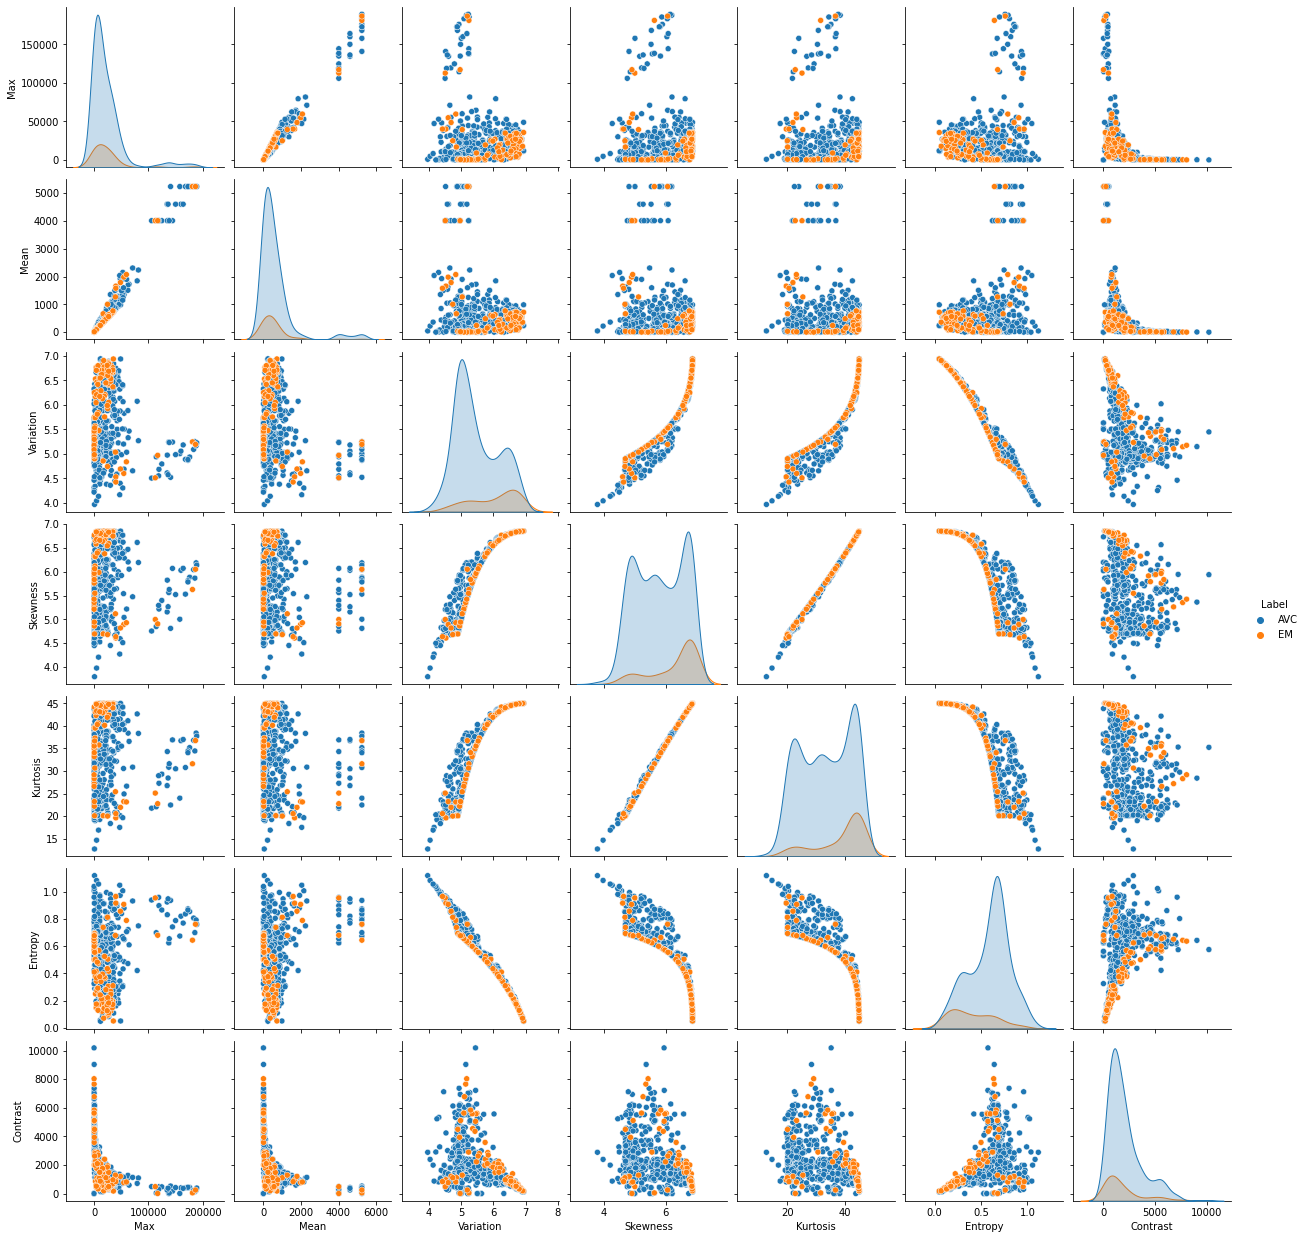

In [11]:
sns.pairplot(df, vars=['Max','Mean','Variation','Skewness','Kurtosis','Entropy','Contrast'], hue='Label')

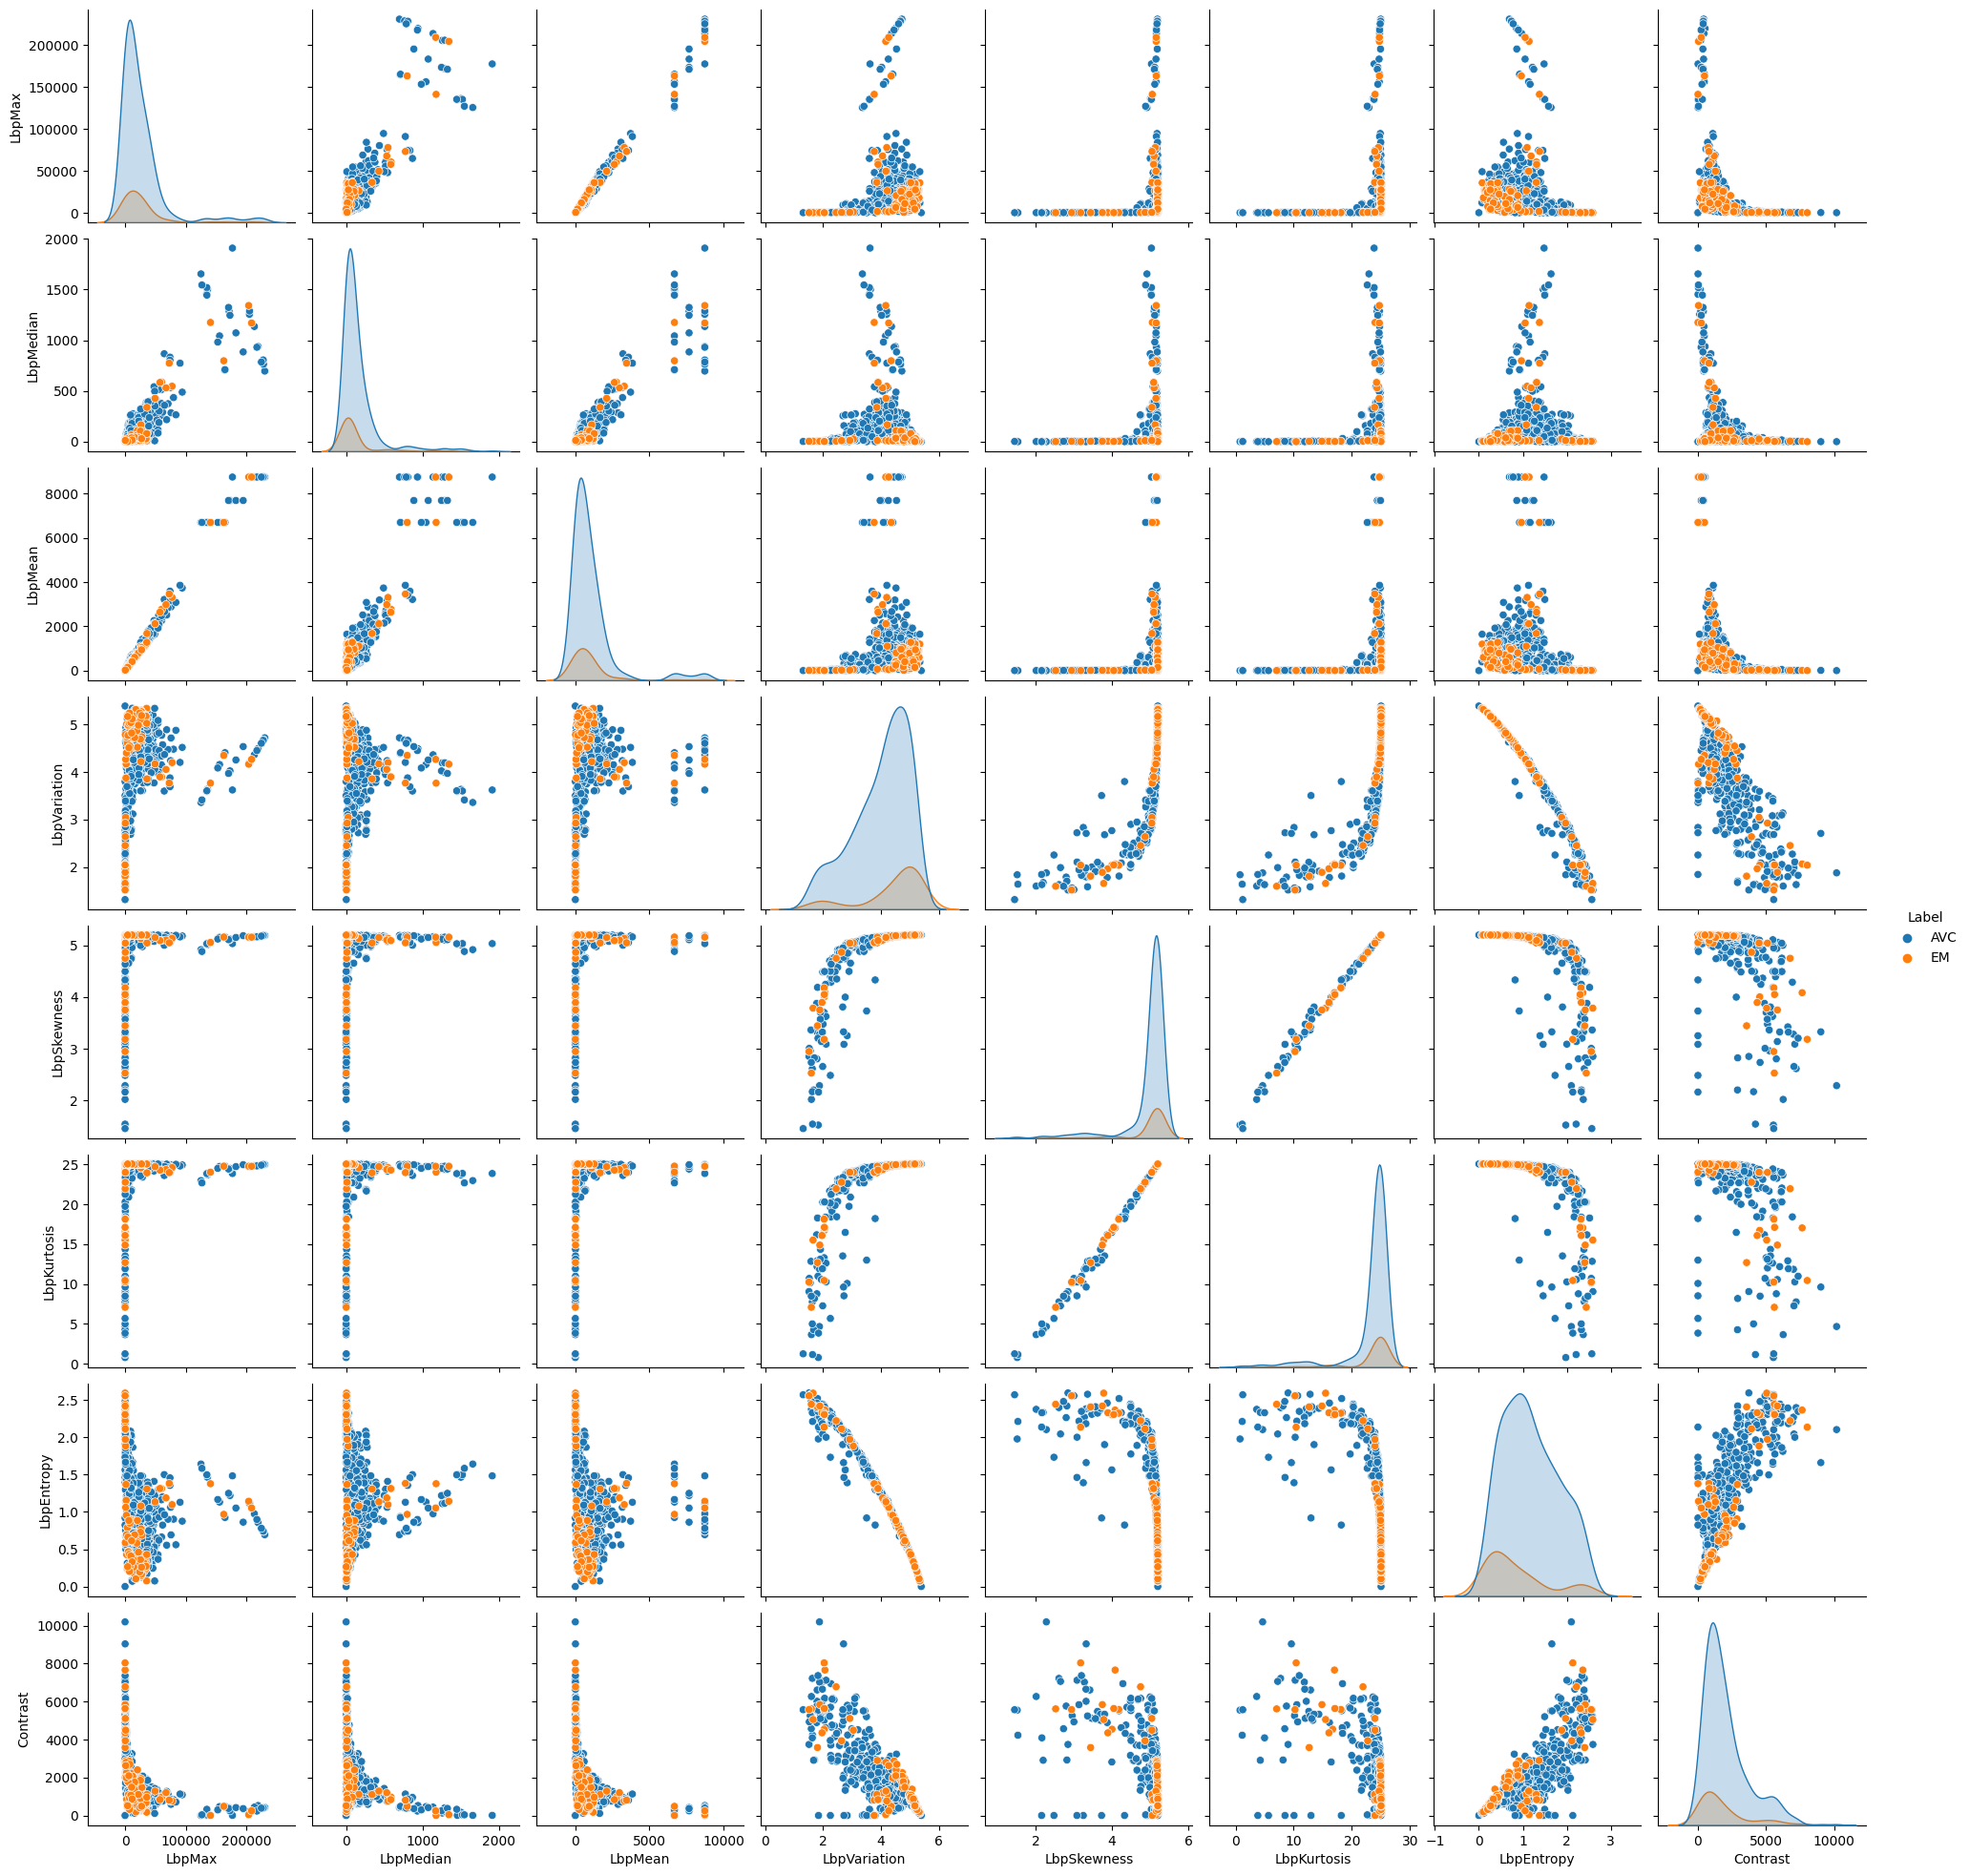

In [12]:
sns.pairplot(df, vars=['LbpMax','LbpMedian', 'LbpMean','LbpVariation','LbpSkewness','LbpKurtosis','LbpEntropy','Contrast'], hue='Label')

From the above, it is visible that the best clusters appear to occur using a combination of contrast with other attributes, especially historgram entropy, variation and skewness.

In [13]:
# df.to_csv(os.path.join(interim_dir, "attributes.csv"), index=False)
# df = pd.read_csv(os.path.join(interim_dir, "attributes.csv"))

Here we declare a function to cross validate a classifier using a column which values must be kept together (i.e. in training or validation set), so as to not split same patient MRI sections in different sets.

In [14]:
def cross_validate_by_patient(estimator, cv, data, x_vars, y_vars, keep_together_column):
    keep_together_list = data[keep_together_column]
    _, idxs_kt = np.unique(keep_together_list, return_index=True)
    X = data[x_vars]
    y = data[y_vars]
    metrics = {
        'roc_auc':[], 'accuracy':[], 'balanced_accuracy':[], 'estimator':[], 'confusion_matrix': []
    }
    # print(idxs_kt[inverse_ns])
    for (train_idx_kt, val_idx_kt) in cv.split(np.zeros(len(idxs_kt)), y[idxs_kt]):
        # print('split', 0, df.loc[idxs_kt[train_idx_kt], ["Label", "PatientId"]])
        train_idx = np.concatenate([np.argwhere(np.array(keep_together_list) == keep_together) for keep_together in keep_together_list[idxs_kt[train_idx_kt]]]).flatten()
        val_idx = np.concatenate([np.argwhere(np.array(keep_together_list) == keep_together) for keep_together in keep_together_list[idxs_kt[val_idx_kt]]]).flatten()

        # print(train_idx)

        X_train = X.loc[train_idx, :]
        y_train = y.loc[train_idx]
        X_val = X.loc[val_idx, :]
        y_val = y.loc[val_idx]

        new_estimator = copy.deepcopy(estimator)
        new_estimator.fit(X_train, y_train)
        metrics['estimator'].append(new_estimator)
        y_pred = new_estimator.predict(X_val)
        metrics['roc_auc'].append(roc_auc_score(y_val == data[y_vars][0], y_pred == data[y_vars][0]))
        metrics['accuracy'].append(accuracy_score(y_val == data[y_vars][0], y_pred == data[y_vars][0]))
        metrics['balanced_accuracy'].append(balanced_accuracy_score(y_val == data[y_vars][0], y_pred == data[y_vars][0]))
        metrics['confusion_matrix'].append(confusion_matrix(y_val, y_pred))
    return metrics

Then we train the model using that cross-validation function. It is also worth to notice that we decided to use 5-fold strafied split, since our dataset is clearly imbalanced. Then, some SVM kernels were tested, and the one that showed better results was the sigmoid one. Also, input attributes were narrowed to only histogram entropy and GLCM constract. With this variables set, we chose the model with the highest balanced accuracy, the mean value from sensitivity and specificity, which is also recommended for imbalanced datasets. Then the model of split index 2 was chosen.

In [15]:
skf = StratifiedKFold(5)
svc = SVC(kernel='sigmoid', gamma='scale')

metrics = cross_validate_by_patient(estimator=svc, cv=skf, data=df, x_vars=["Entropy", "Contrast"], y_vars='Label', keep_together_column='PatientId')
pd.DataFrame.from_dict(metrics)

,roc_auc,accuracy,balanced_accuracy,estimator,confusion_matrix
0,0.534066,0.747748,0.534066,SVC(kernel='sigmoid'),"[[79, 12], [16, 4]]"
1,0.461722,0.713178,0.461722,SVC(kernel='sigmoid'),"[[90, 20], [17, 2]]"
2,0.674779,0.821138,0.674779,SVC(kernel='sigmoid'),"[[96, 17], [5, 5]]"
3,0.451287,0.725664,0.451287,SVC(kernel='sigmoid'),"[[81, 15], [16, 1]]"
4,0.505545,0.738095,0.505545,SVC(kernel='sigmoid'),"[[90, 11], [22, 3]]"


The confusion matrix of that chosen model is more clearly shown below.

Text(0.5, 1.0, 'Confusion matrix for the selected SVM classifier')

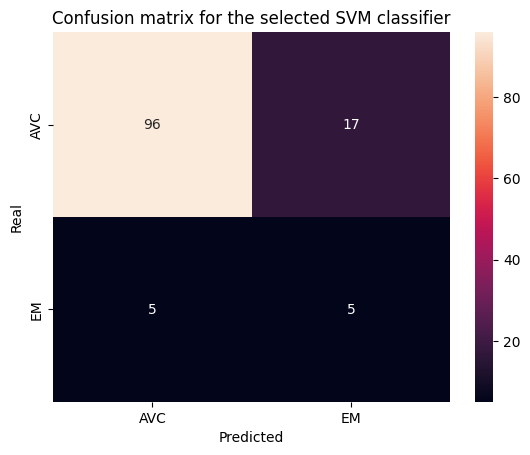

In [16]:
our_estimator_idx = 2

sns.heatmap(metrics['confusion_matrix'][our_estimator_idx], xticklabels=['AVC', 'EM'], yticklabels=['AVC', 'EM'], annot=True)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion matrix for the selected SVM classifier')

In [17]:
our_estimator = metrics['estimator'][our_estimator_idx]
with open('../models/estimator.pkl', 'wb') as f:
    pickle.dump(our_estimator, f)

Then, the test dataset is tried. Here we predict the test images using the chosen previous trained model.

In [22]:
img_list = glob.glob(os.path.join(test_dir,'*.png'))

In [34]:
texture_list = []
for img_path in img_list:
    mask_path = get_mask_path(img_path)
    if not os.path.exists(mask_path):
        continue

    img = cv.imread(img_path, cv.IMREAD_UNCHANGED)
    if img is None:
        continue

    mask = cv.imread(mask_path, cv.IMREAD_UNCHANGED)
    if mask is None:
        continue

    normed = tanh_modified_norm(img).astype(np.uint8)

    masked = normed * (mask == mask.max())

    masked_cropped, _ = crop_zero_borders(masked)

    hist, _ = np.histogram(masked_cropped, bins=50)
    hist_attr = get_histogram_attributes(hist)

    distances = [5]
    angles = [60]
    glcm = graycomatrix(masked_cropped, distances=distances, angles=angles, levels=256, symmetric=False, normed=False)
    a = graycoprops(glcm, prop='contrast').flatten()
    contrast = a[0]

    lbp, lbp_hist, lbp_bins = get_lbp_histogram(masked_cropped)
    lbp_attr = get_histogram_attributes(lbp_hist, 'Lbp')

    label = img_path.split('/')[-2]

    patient_id = img_path.split('/')[-1].split('_')[0]

    flair_id = os.path.splitext(img_path.split('/')[-1].split('_FLAIR')[1])[0]

    attributes = {
        'Contrast': contrast,
        'Label': label,
        'PatientId': patient_id,
        'FlairId': flair_id,
    }
    attributes.update(hist_attr)
    attributes.update(lbp_attr)

    texture_list.append(attributes)

df = pd.DataFrame(texture_list)

In [35]:
df

,Contrast,Label,PatientId,FlairId,Max,Mean,Variation,Median,Skewness,Kurtosis,Entropy,LbpMax,LbpMean,LbpVariation,LbpMedian,LbpSkewness,LbpKurtosis,LbpEntropy
0,1397.323912,SLE,600,11,3295,70.14,6.574883,0.0,6.835847,44.825861,0.270082,3295,116.900000,5.049460,2.5,5.196001,25.011093,0.373714
1,942.477570,SLE,600,12,6867,145.36,6.611520,0.0,6.839294,44.857547,0.251271,6867,242.266667,5.078152,8.5,5.198320,25.026785,0.367646
2,1457.377706,SLE,600,13,4476,96.32,6.506736,0.0,6.822093,44.696464,0.297200,4476,160.533333,4.993399,6.0,5.194420,25.000316,0.429941
3,173.815234,SLE,600,14,30238,609.00,6.950441,0.0,6.856619,45.015693,0.041521,30238,1015.000000,5.346388,4.0,5.199441,25.034294,0.059146
4,165.733416,SLE,600,15,10525,212.04,6.948309,0.0,6.856572,45.015274,0.043005,10525,353.400000,5.344715,0.0,5.199436,25.034262,0.060052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,0.000000,SLE,609,22,15,0.32,6.568152,0.0,6.811704,44.595747,0.233792,6,0.533333,2.256934,0.0,3.247321,11.432440,1.840749
693,796.393388,SLE,609,23,751,15.60,6.739457,0.0,6.841572,44.877416,0.158874,751,26.000000,5.178691,0.0,5.197389,25.020510,0.223626
694,0.000000,SLE,610,13,15,0.40,5.500000,0.0,6.022539,36.176081,0.562335,6,0.666667,2.334524,0.0,2.367731,4.364279,1.639957
695,1773.165714,SLE,610,14,2258,48.40,6.536662,0.0,6.810745,44.586723,0.261167,2258,80.666667,5.013147,3.5,5.196460,25.014241,0.417355


In [36]:
x_vars=["Entropy", "Contrast"]
X_test = df[x_vars]

In [37]:
y_test = our_estimator.predict(X_test)

In [38]:
out = df[['PatientId', 'FlairId']]

In [39]:
out

,PatientId,FlairId
0,600,11
1,600,12
2,600,13
3,600,14
4,600,15
...,...,...
692,609,22
693,609,23
694,610,13
695,610,14


In [42]:
out['Predicted'] = np.where(y_test == 'AVC', 'ischemic', 'demyelinating')

/tmp/ipykernel_9271/684812720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out['Predicted'] = np.where(y_test == 'AVC', 'ischemic', 'demyelinating')


In [43]:
out

,PatientId,FlairId,Predicted
0,600,11,ischemic
1,600,12,ischemic
2,600,13,ischemic
3,600,14,demyelinating
4,600,15,demyelinating
...,...,...,...
692,609,22,demyelinating
693,609,23,ischemic
694,610,13,demyelinating
695,610,14,ischemic


The results is then saved to file with the specified format.

In [44]:
out.to_csv(os.path.join(test_dir, "predicted.txt"), index=False, sep=" ", header=False)